In [1]:
from mc2hessian import (LocalPDF, XGrid, Flavors, invcov_sqrtinvcov,
                        comp_hess, DEFAULT_EPSILON)
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
fl = Flavors()
xgrid = XGrid()
pdf = LocalPDF('1000rep', 1000, xgrid, fl, 1, eps=0.25)
index = pdf.fin
indextmp = np.copy(index)
nx = xgrid.n
nf = fl.n

# build covmat
cov = pdf.pdfcovmat()
invcov, sqrtinvcov = invcov_sqrtinvcov(cov)

 [Info] Keeping  242 nf*nx using (1-std/68cl) <= eps = 0.25
 [Warning] Removing eigenvalue 0 -3.86149087968e-17
 [Warning] Removing eigenvalue 1 -1.64385511927e-17
 [Warning] Removing eigenvalue 2 -7.30146553535e-18
 [Warning] Removing eigenvalue 3 -1.44691652489e-18
 [Warning] Removing eigenvalue 4 -6.0694333774e-20
 [Warning] Removing eigenvalue 5 -5.23455499837e-20
 [Warning] Removing eigenvalue 6 -2.51740134208e-20
 [Warning] Removing eigenvalue 7 -2.00074305352e-20
 [Warning] Removing eigenvalue 8 -1.87149532612e-20
 [Warning] Removing eigenvalue 9 -1.29993910382e-20
 [Warning] Removing eigenvalue 10 -6.55177987523e-21
 [Warning] Removing eigenvalue 11 -6.41854418732e-21
 [Warning] Removing eigenvalue 12 -5.84692989199e-21
 [Warning] Removing eigenvalue 13 -3.73270188283e-21
 [Warning] Removing eigenvalue 14 -3.68073857631e-21
 [Warning] Removing eigenvalue 15 -3.35165574958e-21
 [Warning] Removing eigenvalue 16 -3.23910617033e-21
 [Warning] Removing eigenvalue 17 -2.95734913243e-

In [3]:
p = d = pdf.n_rep
h = len(sqrtinvcov)
A = np.zeros(shape=(h, p))
for t in range(p):
    for fl in range(nf):
        for ix in range(nx):
            i = nx*fl + ix
            A[i, t] = pdf.xfxQ[t, fl, ix] - pdf.f0[fl, ix]
B = np.dot(sqrtinvcov, A)

Compute Singular value decomposition
----------------------------------------

In [23]:
U,s,V = la.svd(B, full_matrices=False)
#Remove small singular values
goods =np.argwhere(s>1e-5).ravel()
s = s[goods]
U = U[:, goods]
V = V[goods, :]
#Check this does not affect the result
np.allclose(B, np.dot(U, np.dot(np.diag(s), V)))

True

In [24]:
#All non-small singular values are the same!
pd.Series(s).describe()

count    242.000000
mean      31.606961
std        0.000168
min       31.605123
25%       31.606961
50%       31.606961
75%       31.606961
max       31.608810
dtype: float64

In [97]:
projs = np.sum(np.abs(V),axis=0)

In [98]:
selected = np.argsort(projs)[-100:]

In [121]:
s2 = np.argsort(np.sum(np.abs(np.dot(V.T,V)), axis=1))[:100]

Compare results for linear system
======

In [122]:
#Random basis of 100 replicas
def make_random_sel(neig):
    random_sel = np.random.choice(np.arange(1000), replace=False,size=neig)
    random_sel.sort()
    return random_sel
random_sel = make_random_sel(100)

In [123]:
#
gab = np.array([int(x) for x in """ 1   2   3   5   6   7   8   9  10  11  13  14  15  17  19  20  21  22
  23  24  25  27  28  29  31  32  33  34  35  37  38  39  42  43  44  45
  46  47  48  49  50  51  54  55  56  57  58  59  60  64  65  66  67  69
  70  71  72  73  75  77  79  80  81  83  84  86  89  91  92  94  95  96
  97  98 110 150 153 222 338 415 442 465 500 517 560 614 640 661 676 706
 725 739 771 779 847 860 873 874 890 973""".split()]) - 1

Sum of residuals for "best"

In [124]:

c, res, rank, s = la.lstsq(B[:,s2], B)
print(np.sum(res))

141858.008327


Sum of residuals for random

In [137]:

c, res, rank, s = la.lstsq(B[:,random_sel], B)
print(np.sum(res))

141857.99462


Best of 1000 random

In [120]:
def many_rand():
    for _ in range(1000):
        c, res, rank, s = la.lstsq(B[:,make_random_sel(100)], B)
        yield (np.sum(res))
print(min(many_rand()))

141857.980629


Sum of residuals for GA

In [62]:
c, res, rank, s = la.lstsq(B[:,gab], B)
print(np.sum(res))

141858.002661


Check critical $N_{eig}$
==============

In [27]:
#Random basis of 240 replicas
random_sel = np.random.choice(np.arange(1000), replace=False,size=240)
random_sel.sort()
c, res, rank, s = la.lstsq(B[:,random_sel], B)
print(np.sum(res))

1998.00131138


In [28]:
#Random basis of 241 replicas
random_sel = np.random.choice(np.arange(1000), replace=False,size=241)
random_sel.sort()
c, res, rank, s = la.lstsq(B[:,random_sel], B)
print(np.sum(res))

999.002313795


In [30]:
#Random basis of 242 replicas
random_sel = np.random.choice(np.arange(1000), replace=False,size=242)
random_sel.sort()
c, res, rank, s = la.lstsq(B[:,random_sel], B)
print(np.sum(res))

1.54741153968e-23


In [34]:
l = []
neigs = np.arange(242,50,-1)
for i in neigs:
    random_sel = np.random.choice(np.arange(1000), replace=False,size=i)
    random_sel.sort()
    c, res, rank, s = la.lstsq(B[:,random_sel], B)
    l.append(np.sum(res))


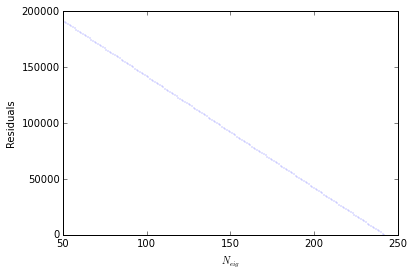

In [40]:
plt.plot(neigs,l, '.', markersize=0.5)
plt.ylabel("Residuals")
plt.xlabel("$N_{eig}$")